# Satellite data (part 3)
----
J. Potemra
April 2022

----

# Outline
In this notebook we will look at a variety of satellite data and apply these data to different questions.  We will first start with sea level as measured by altimetry and do some comparisons to tide gauge data.  Next, we'll have a look at surface temperature and try do some trend analysis.  After that, we'll have a look at scatterometer winds and compute Ekman currents.  Finally, we'll have a look at ocean ocean.

# 1. Satellite data: Sea level

In this exercise we will try to access and plot satellite-derived data.  To make things even more flexible, we will read data from remote data services (_i.e._, there will be no need to access data on the SOEST disks or download anything to your local machine).  As mentioned before, NASA PO.DAAC, the APDRC and PacIOOS are all good places to look for data:

 * https://thredds.jpl.nasa.gov/thredds/catalog.html
 * http://apdrc.soest.hawaii.edu/data/data.php
 * https://pacioos.org/thredds

Additionally, we will make use of the mapping functions within cartopy.  This is just one way to draw coastlines; GeoPandas and matplotlib are two others.

As usual, the first thing we want to do is import all the necessary packages:
<ul>
    <li> Numpy for numerical analysis and array handling
    <li> Matplotlib, pyplot for plots
    <li> cartopy for coastlines
    <li> netCDF4 to read the data from remote (OPeNDAP) servers (recall xarray is another way to do this)
</ul>

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
# this for colormaps
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

## 1A. Plot map of sea level from AVISO at particular time
In this first example we'll try make a plot of sea level anomalies from satellite altimeter, specifically the AVISO product.  We can get the proper URL from the JPL PO.DAAC server.

In [2]:
# specify the URL to the data set, then create data object
URL = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/SeaSurfaceTopography/aviso/dynamic_topo_1deg_1mo/zos_AVISO_L4_199210-201012.nc'
file = nc.Dataset(URL)

In [3]:
# We can optionally print out the variables and metadata in the file
print(file.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1950-01-01 00:00:00
    calendar: standard
    axis: T
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (219,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (219, 2)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    bounds: lat_bnds
    units: degrees_north
    axis: Y
    long_name: latitude
    standard_name: latitude
unlimited dimensions: 
current shape = (180,)
filling off, 'lat_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 lat_bnds(lat, bnds)
unlimited dimensions: 
current shape = (180, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    bounds: lon_bnds
    units: degrees_east
    axis: X
    long_name: longitude
    standard_name: longitude
unlimited dimensions: 
current shape = (360,)
fil

In [6]:
# Next, as an example, let's extract data for a specific time, e.g.,
# extract lat, lon, and sea level anomaly at time=1
sat_lat  = file.variables['lat'][:]
sat_lon  = file.variables['lon'][:]
sat_time = file.variables['time'][:]
sat_sea_level = file.variables['zos'][1,:,:]

# NOTE: it's usually good practice to "close" the file after done
#   extracting.  To do this:
#file.close()
#   but we will be needing this later, so I'll leave this commented out.

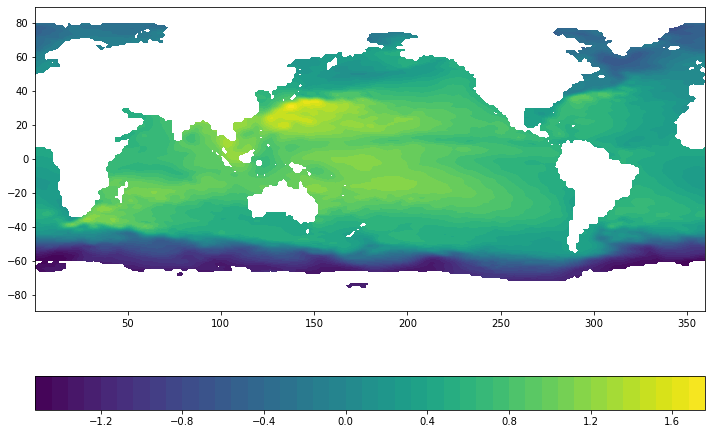

In [5]:
# Now let's make a quick plot to see what we have
fig=plt.figure( figsize = (12, 8) )
plt.contourf(sat_lon, sat_lat, sat_sea_level, 50)
plt.colorbar(orientation='horizontal');

### Side note about time

In this example, we arbitrarily choose time index 1 (_i.e._, the SECOND time-step).  How can we determine what date this corresponds to?  And, maybe we want to select a different time, but not on index but on date.  How can we do this?

It turns out the file does have metadata that tells us how the time (number) corresponds to a date.  We can use this, and the datetime function to convert.

In [8]:
# first, let's have a look at the units on the variable time:

print(file.variables['time'].units)

days since 1950-01-01 00:00:00


In [10]:
# and what are the first and last values, difference between 
#   successive times, and how many are there?
print("the first time is ", sat_time[0])
print("the last time is ", sat_time[-1])
print("the range is ", sat_time[-1]-sat_time[0]+1)
print("number of times ", len(sat_time))
#print(sat_time[0],sat_time[-1],sat_time[1]-sat_time[0],len(sat_time))

the first time is  15629.5
the last time is  22264.5
the range is  6636.0
number of times  219


In [11]:
# okay, time is a number from 15,629.5 to 22,264.5 
#   that represents "days since Jan 1, 1950 at 00:00:00",
#   there are 219 of them, and they appear to be monthly
# how to convert to a date?
#   the netCDF4 package has a "num2date" method, and this
#   requires a variable name and unit; we can use this,
#   then make a date with Pandas datetime like before (!)

time_convert = nc.num2date(file.variables['time'],
                           file.variables['time'].units,
                           only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

In [12]:
print(date)

DatetimeIndex(['1992-10-16 12:00:00', '1992-11-16 00:00:00',
               '1992-12-16 12:00:00', '1993-01-16 12:00:00',
               '1993-02-15 00:00:00', '1993-03-16 12:00:00',
               '1993-04-16 00:00:00', '1993-05-16 12:00:00',
               '1993-06-16 00:00:00', '1993-07-16 12:00:00',
               ...
               '2010-03-16 12:00:00', '2010-04-16 00:00:00',
               '2010-05-16 12:00:00', '2010-06-16 00:00:00',
               '2010-07-16 12:00:00', '2010-08-16 12:00:00',
               '2010-09-16 00:00:00', '2010-10-16 12:00:00',
               '2010-11-16 00:00:00', '2010-12-16 12:00:00'],
              dtype='datetime64[ns]', length=219, freq=None)


In [16]:
# We now have a "proper" date, how can we search?
#  use the "get_loc" method on our date

print(date.get_loc('1997-12-15'))
print(date[62])

slice(62, 62, None)
1997-12-16 12:00:00


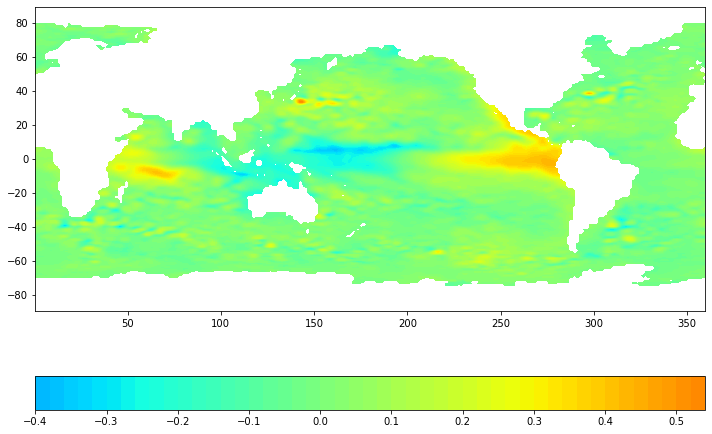

In [17]:
# okay, now let's redo our plot, but now select the 63rd time-step
# that corresponds to December 1997:
sat_sea_level1 = file.variables['zos'][51,:,:]
sat_sea_level2 = file.variables['zos'][62,:,:]
fig=plt.figure( figsize = (12, 8) )
levels = np.linspace(-1.4,1.4,51)
plt.contourf(sat_lon, sat_lat, sat_sea_level2-sat_sea_level1, 
             50, vmin = -1.0, vmax = 1.0, cmap = cm.jet)
plt.colorbar(orientation='horizontal')

Now let's copy/paste the map drawing code from last time and polish up the plot

/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


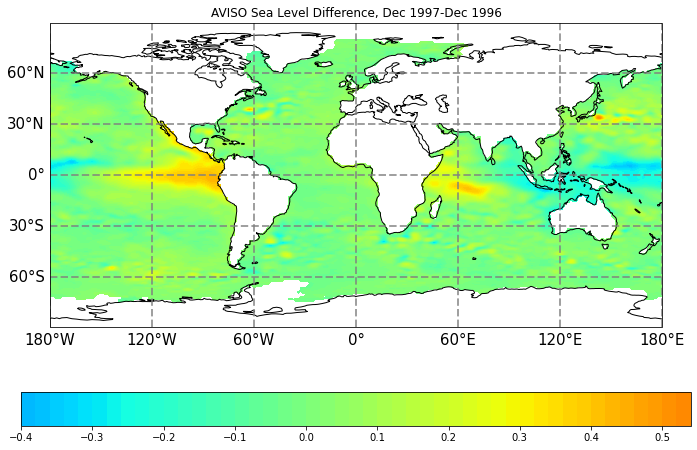

In [18]:
# draw color-shaded plot with map background

# set up the figure
fig=plt.figure( figsize = (12, 8) )

# set projection
ax = plt.axes(projection = ccrs.PlateCarree())

# color-shade sea level ('data') on same projection
plt.contourf(sat_lon, sat_lat, sat_sea_level2-sat_sea_level1, 50,
             vmin=-1.0,vmax=1.0, cmap=cm.jet, transform=ccrs.PlateCarree())

# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add a colorbar and title
plt.colorbar(orientation='horizontal')
plt.title('AVISO Sea Level Difference, Dec 1997-Dec 1996');

## 1B. Make a time-series at a point

Now, let's try and extract a point near Hawaii (roughly 22N, 158W) and plot vs. all time.  Note since we closed the data set, we need to re-open and extract like last time.

In [19]:
# This time let's use the APDRC file, first we "close" the last one
file.close()

URL = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/TOPEX/AVISO_reference/msla_monthly'
file = nc.Dataset(URL)
sat_time = file.variables['time'][:]
sat_lat  = file.variables['lat'][:]
sat_lon  = file.variables['lon'][:]

In [24]:
# We now look for "where" the salellite data set has a measurement near 22N, 158W;
#  note that we don't know the exact resolution of the satellite data set, 
#  so we search within a range.  For example, the satellite may not have data
#  at 21.75, and if we search for lat = 21.75 we'd get nothing back.  On the other
#  hand, if our search is too wide, we may end up with more that one point.
# To do the search, we use the numpy "argwhere" method

# step one, find the index corresponding to our point
J = np.argwhere((sat_lat > 21.5) & (sat_lat < 22.0))
I = np.argwhere((sat_lon > 202) & (sat_lon < 202.5))
print(I,J)

# step two, extract the data at this I,J index
sealevel_hnl_aviso = file.variables['sla'][:,int(I),int(J)]

[[607]] [[524]]


In [25]:
sealevel_hnl_aviso.shape

(208,)

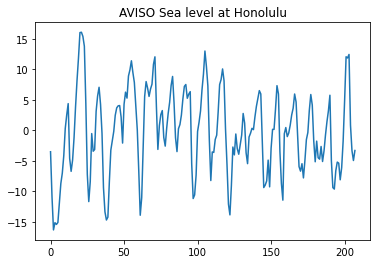

In [26]:
# Make a plot
plt.plot(sealevel_hnl_aviso)
plt.title('AVISO Sea level at Honolulu');

Note that the x-axis is just sequential from 1 to 208, corresponding to the array index (row) of the dataset.  But what we really want is time.  Checking the metadata (see above; time.units) you can see the time values are monthly mean values from December 1992 and are reported in "days since 1-1-1".  This is a standard, but bad, reference used for example in matlab.  It cannot directly convert in python, _e.g._, this will give an error:

    time_convert = nc.num2date(time)
    date = pd.to_datetime(time_convert)
    
So, we'll have to add an extra step.  There are probably many ways to do this, but here let's just use the fact that we know the data start on Dec 15, 1992.  If we subtrac this from all the subsequent days, we have re-referenced the time value to "days since Dec 15, 1992".  In other words:

    date = time - time[0]

will have time as "days since Jan 1, 0001" and date as "days since Dec 15, 1992".  We can then pass this to datetime.

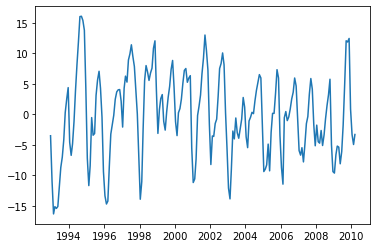

In [27]:
date_aviso = pd.to_datetime(sat_time-sat_time[0], 
                unit='D', origin = pd.Timestamp('1992-12-15 00:00:00'))
plt.plot(date_aviso,sealevel_hnl_aviso);

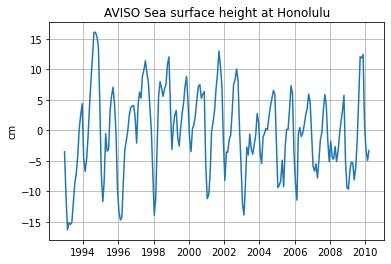

In [28]:
# Now plot with date as the x-axis (and add a grid and title)
plt.plot(date_aviso,sealevel_hnl_aviso)
plt.grid()
plt.title('AVISO Sea surface height at Honolulu')
plt.ylabel('cm');

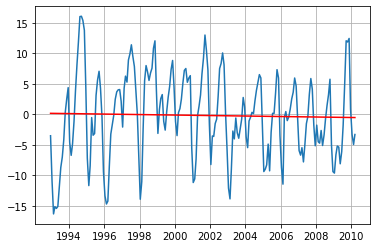

In [29]:
# next step is to fit a line, just line we did with the tide gauges
t = np.arange(0,len(sat_time))
B = np.polyfit(t,sealevel_hnl_aviso,1)
# convert trend in cm/month to cm/decade
trend = B[0]  * 12.0 * 10.0
# cheap way to round to two digits
trend = int(trend*100.0)/100.0
Y = np.polyval(B,t)
plt.plot(date_aviso,sealevel_hnl_aviso)
plt.plot(date_aviso,Y,'r')
plt.grid();

## 1C. Compare to tide gauge data

In [30]:
URL = 'http://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h057.csv'
column_headings = ['year', 'month', 'day', 'hour', 'sealevel_hnl_tideg']
hnl_data = pd.read_csv(URL,names=column_headings)

hnl_data[hnl_data['sealevel_hnl_tideg'] < 0] = np.nan
hnl_data['date_tideg'] = pd.to_datetime(hnl_data.index*3600.0, origin = '01-01-1905 10:00:00', unit='s')
hnl_data = hnl_data.set_index('date_tideg')
hnl_data['sealevel_hnl_tideg'] = ( hnl_data['sealevel_hnl_tideg'] - np.mean(hnl_data['sealevel_hnl_tideg']) ) / 10.0

(8401.0, 14974.0)

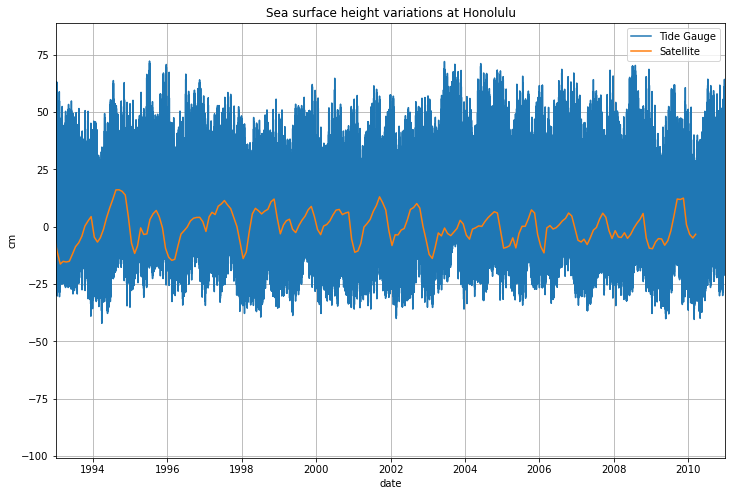

In [31]:
plt.figure(figsize=(12,8))
plt.plot(hnl_data['sealevel_hnl_tideg'],label='Tide Gauge')
plt.plot(date_aviso,sealevel_hnl_aviso,label='Satellite')
plt.title('Sea surface height variations at Honolulu')
plt.xlabel('date')
plt.ylabel('cm')
plt.grid()
plt.legend()
plt.xlim([dt.datetime(1993, 1, 1), dt.datetime(2010, 12, 31)])

In [32]:
type(hnl_data)

pandas.core.frame.DataFrame

In [33]:
hnl_data2 =  hnl_data.resample('M').mean()

(8401.0, 14974.0)

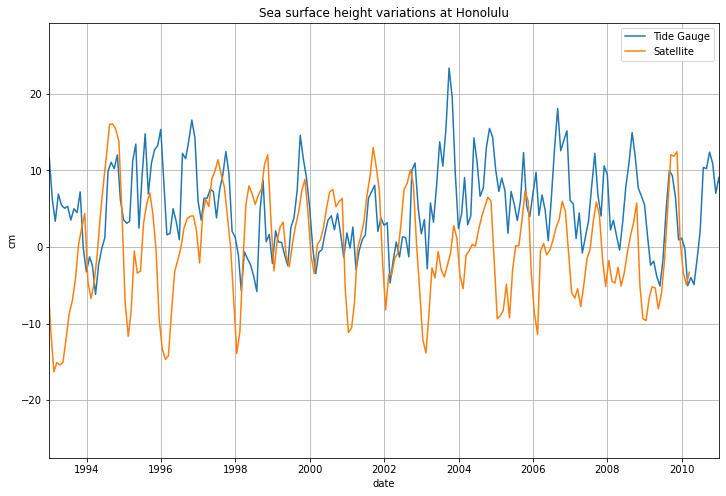

In [34]:
plt.figure(figsize=(12,8))
plt.plot(hnl_data2['sealevel_hnl_tideg'],label='Tide Gauge')
plt.plot(date_aviso,sealevel_hnl_aviso,label='Satellite')
plt.title('Sea surface height variations at Honolulu')
plt.xlabel('date')
plt.ylabel('cm')
plt.grid()
plt.legend()
plt.xlim([dt.datetime(1993, 1, 1), dt.datetime(2010, 12, 31)])

# 2. Satellite data: Sea surface temperature

In this exercise we will try to access and plot satellite-derived sea surface temperature (SST) and sea ice data.  Like last class, we will read data from remote data services.  Here we add a new one, a NOAA THREDDS server:

 * https://thredds.jpl.nasa.gov/thredds/catalog.html
 * http://apdrc.soest.hawaii.edu/data/data.php
 * https://pacioos.org/thredds 
 * https://psl.noaa.gov/thredds/aggregations.html

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [2]:
# Read data from NCDC THREDDS server: SST, SST anomales and ice concentrations
URL1 = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/sst.mean.nc'
URL1a = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/sst.anom.nc'
URL2 = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/icec.mean.nc'

dataset1 = nc.Dataset(URL1)
dataset1a = nc.Dataset(URL1a)
dataset2 = nc.Dataset(URL2)

In [37]:
# Note that there is a variable called "time" and in this
#   the units are days since 1800-01-01 00:00:0
# We can convert this to datetime like last time

time_convert = nc.num2date(dataset1.variables['time'],dataset1.variables['time'].units,
                          only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

## 2A. Make lat/lon contour plots of SST and ice concentrations

Here we can pick a specific time, _e.g._, Feb 15, 2020, and just read that date.  Since the times were convered to datetime, this is straightforward:
          
    date = datetime(2020,3,15,0) 
    timeindex = date2index(date,timevar)
    
In this example, let's use the python indexing syntax of [-1] to get the last time available.  This is sometimes helpful when running a regular script (_e.g._, get the most recent file every day without knowing what that is
     
    timeindex = -1

In [38]:
# extract all lats, lons and variables for time at the last index
timeindex = -1
sst = dataset1.variables['sst'][timeindex,:]
sst_anom = dataset1a.variables['anom'][timeindex,:]
ice = dataset2.variables['icec'][timeindex,:]
lat = dataset1.variables['lat'][:]
lon = dataset1.variables['lon'][:]

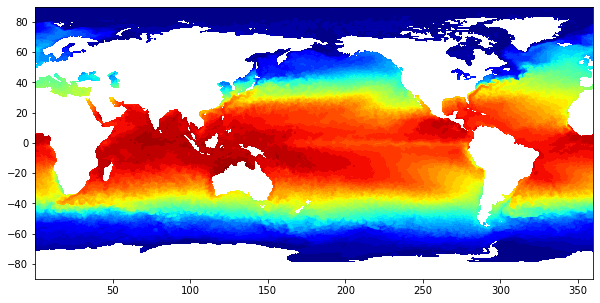

In [39]:
# make a quick plot
fig = plt.figure(figsize=(10, 5))
plt.contourf(lon,lat,sst,50,cmap=cm.jet);

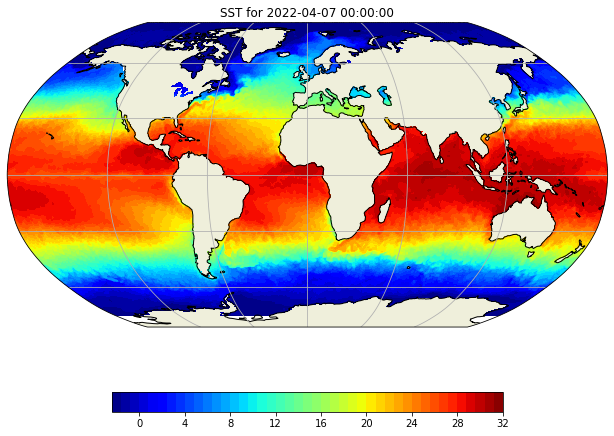

In [40]:
# make a much nicer plot

# set up the figure
fig=plt.figure( figsize = (14, 8) )

# set projection
# these work
ax = plt.axes(projection = ccrs.Robinson(central_longitude=0))
#ax = plt.axes(projection = ccrs.Mollweide(central_longitude=0))
#ax = plt.axes(projection = ccrs.Orthographic(central_longitude=0))
#ax = plt.axes(projection = ccrs.Orthographic(central_longitude=180))
#ax = plt.axes(projection = ccrs.NorthPolarStereo())
#ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())

# don't know why these do not
#ax = plt.axes(projection = ccrs.Robinson(central_longitude=180))
#ax = plt.axes(projection = ccrs.Mollweide(central_longitude=180))

# add grid lines, coastlines and color land values
ax.gridlines()
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)

# color-shade SST with 50 colors using the "jet" color scheme
# this works
plt.contourf(lon,lat,sst,50,transform=ccrs.PlateCarree(),cmap=cm.jet)

# these plot as rectangles
#plt.contourf(lon,lat,sst,50,transform=ccrs.Robinson(),cmap=cm.jet)
#plt.contourf(lon,lat,sst,50,cmap=cm.jet)

# draw title
ax.set_title('SST for %s'%date[-1])

# add colorbar
plt.colorbar(orientation='horizontal',shrink=0.5)

# sea ice
#plt.contourf(lon,lat,ice,4,transform=ccrs.PlateCarree(),cmap=cm.gist_gray);
#plt.colorbar(orientation='horizontal',shrink=0.3);

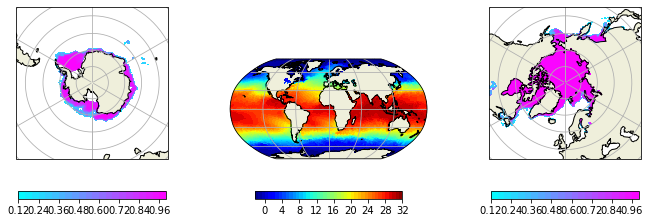

In [41]:
# Now make three plots, two polar plots and one global:
# colorbars at
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.figure(figsize=(12,4))

# first plot on the left: sea ice at the South Pole
ax1 = plt.subplot(1,3,1,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.LAND)
ax1.set_extent([-180, 180, -45, -90], ccrs.PlateCarree())
plt.contourf(lon,lat,ice,25,transform=ccrs.PlateCarree(),cmap=cm.cool)
plt.colorbar(orientation='horizontal',shrink=0.75)

# second plot in the middle; SST 
ax2 = plt.subplot(1,3,2,projection=ccrs.Robinson(central_longitude=0))
ax2.gridlines()
ax2.add_feature(cf.COASTLINE)
ax2.add_feature(cf.LAND)
plt.contourf(lon,lat,sst,50,transform=ccrs.PlateCarree(),cmap=cm.jet)
plt.colorbar(orientation='horizontal',shrink=0.75)

ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.gridlines()
ax3.add_feature(cf.COASTLINE)
ax3.add_feature(cf.LAND)
ax3.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
plt.contourf(lon,lat,ice,25,transform=ccrs.PlateCarree(),cmap=cm.cool)
plt.colorbar(orientation='horizontal',shrink=0.75);

## 2B. Data at a point: computing the annual cycle

Like last lecture, we will extract a time-series at a particular point. You will notice in some places (like here in Hawaii), the seasonal cycle dominates the signal.  We usually want to remove that and look at "seasonal anomalies," and this means we first need to compute the mean seasonal cycle.  In some cases this gets tricky, _e.g._, with hourly data, irregularly spaced data and so on.

Pandas provides a nice way around this.

The data we've read in thus far are daily, over a long record.  This will still work, but may overload the server, so instead we'll read in a monthy mean product called "OISST", or "Optimally Interpolated Sea Surface Temperature".

Recall we have our old data sets still open, so it's good practice to first close these.

In [42]:
dataset1.close()
dataset1a.close()
dataset2.close()

In [43]:
# Open the new data set, monthly mean SST from NOAA
URL = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
file = nc.Dataset(URL)

# Extract lat/lon and time
lat = file.variables['lat'][:]
lon = file.variables['lon'][:]
time = file.variables['time'][:-1]

In [44]:
# like before, let's search for a point near Hawaii
# step one, find the index corresponding to our point
J = np.argwhere((lat > 21.0) & (lat < 22.0))
I = np.argwhere((lon > 201.0) & (lon < 202.5))

In [48]:
# extract SST at the specified point
# NOTE we want an even number of years, i.e., number of
# time points is multiple of 12
sst_HI = file.variables['sst'][2:-1,int(J),int(I)]

In [49]:
len(sst_HI)/12

40.0

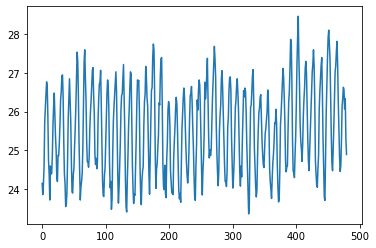

In [50]:
plt.plot(sst_HI);

In [51]:
# Again, like last time, convert the time variable to something more useful
time_convert = nc.num2date(file.variables['time'][2:-1],file.variables['time'].units,
                          only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

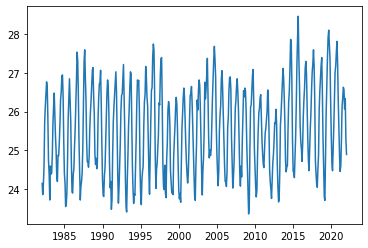

In [52]:
plt.plot(date,sst_HI)

We now wish to construct a monthly climatology, _i.e._, average January, average February, average March, _etc._  This would (and could) be done in a loop, and can get a little complicated.  This would be especially complex if we had daily data.  Pandas, however, has a nice method called "groupby" which will allow us to make a climatology quickly.  The steps are:
 1. put the SST date and data into a Pandas DataFrame
 2. compute the mean after grouping by month
 3. repeat the monthly means for the entire time record (_e.g._, if we have ten years of data, we'd repeat the mean seasonal cycle ten times)
 4. add the climatology to the DataFrame

In [53]:
# make dataframe
df = pd.DataFrame(sst_HI,date)
df.columns = ['SST']
print(df.head())

                  SST
1982-02-01  24.139999
1982-03-01  23.850000
1982-04-01  24.129999
1982-05-01  24.580000
1982-06-01  25.730000


In [54]:
# compute climatology: here we group the data by month, then compute the mean
mean_season = df.groupby(df.index.month).mean()

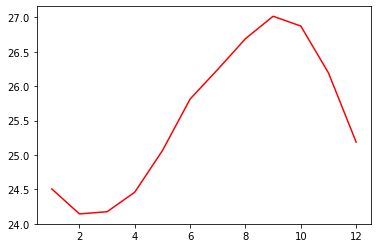

In [55]:
# we can now make a quick plot
plt.plot(mean_season,'r')

In [58]:
len(step3)

482

In [64]:
# Next, we want to add a second column to our DataFrame that
#  includes the mean seasonal cycle.  To do this we have to
#  repeat the 12-month variable "mean_season" over the entire
#  record.

# 1. collapse the variable to a single dimension
step1 = mean_season.squeeze()

# 2. repeat (tile) the data over all years
step2 = np.tile(step1, len(df)//len(mean_season))

# 3. pad the final rows (the above works on complete years,
#   and this data set has four extra months)
print(len(df)-len(step2))
step3 = np.append(step2,[mean_season.iloc[0],mean_season.iloc[1]])
print(len(step3))

# 4. finally, we add this to our DataFrame
df['mmean'] = step3[1:-1]

0
482


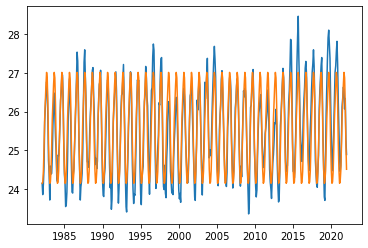

In [61]:
plt.plot(df)

Text(0.5, 1.0, 'SST Seasonal Anomalies near Hawaii')

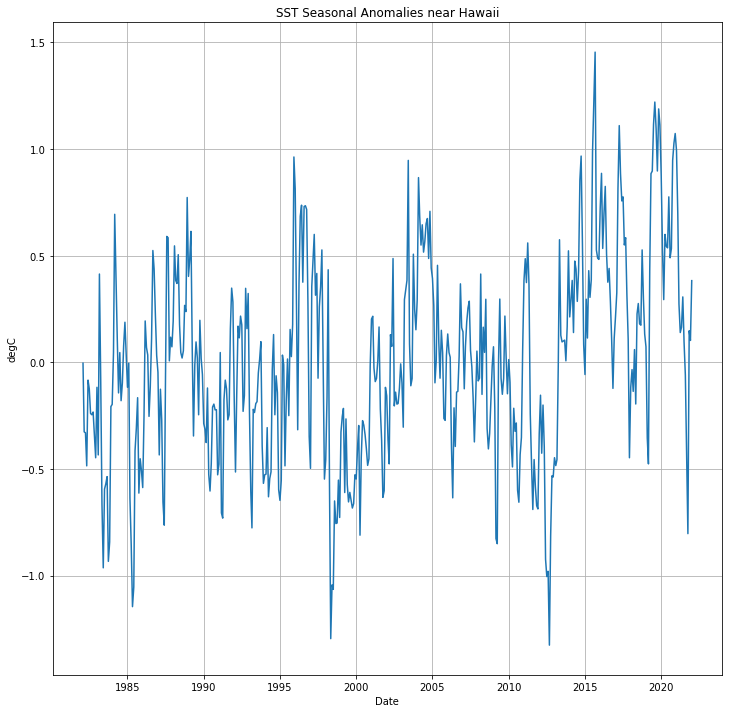

In [62]:
fig = plt.figure(figsize=(12,12))
plt.plot(date,df['SST']-df['mmean'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('degC')
plt.title('SST Seasonal Anomalies near Hawaii')
#plt.xlim([dt.datetime(1981, 12, 1), dt.datetime(1982, 11, 30)])

0


Text(0.5, 1.0, 'SST Seasonal Anomalies near Galapagos')

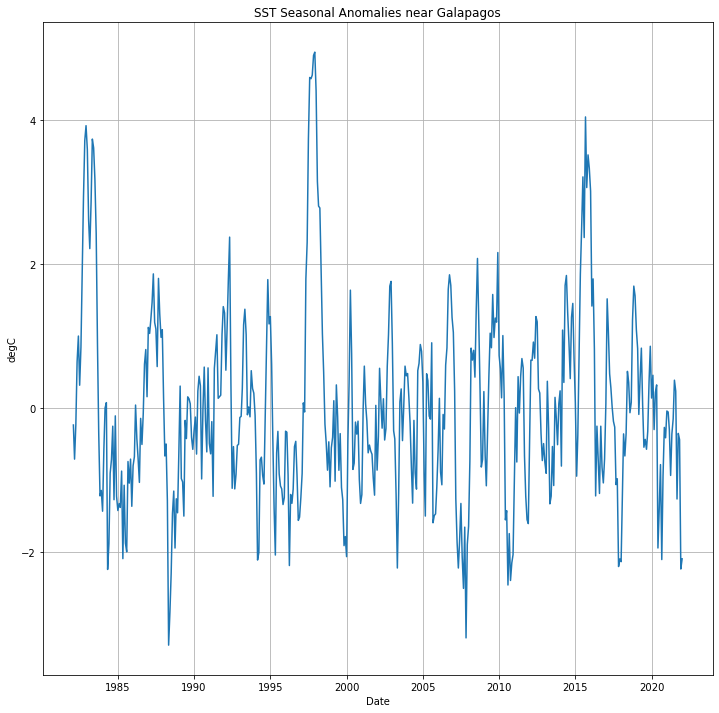

In [67]:
J = np.argwhere((lat > 0.0) & (lat < 1.0))
I = np.argwhere((lon > 260.0) & (lon < 261))
sst_GA = file.variables['sst'][2:-1,int(J),int(I)]
df2 = pd.DataFrame(sst_GA,date)
df2.columns = ['SST']
mean_season = df2.groupby(df2.index.month).mean()
step1 = mean_season.squeeze()
step2 = np.tile(step1, len(df2)//len(mean_season))
print(len(df2)-len(step2))
step3 = np.append(step2,[mean_season.iloc[0],mean_season.iloc[1]])
df2['mmean'] = step3[1:-1]

fig = plt.figure(figsize=(12,12))
plt.plot(date,df2['SST']-df2['mmean'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('degC')
plt.title('SST Seasonal Anomalies near Galapagos')